In [371]:
import chardet
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

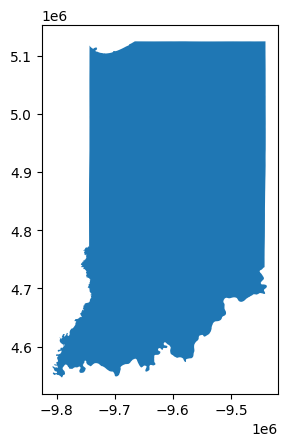

In [2]:
us_states = "data/map_data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
IN_basemap = gpd.read_file(us_states,crs=4326)
IN_basemap = IN_basemap[IN_basemap['NAME']=="Indiana"]
IN_basemap = IN_basemap.to_crs(epsg=3857) # WEB MERCATOR (EPSG: 3857), Widely accepted projection, in meters
IN_geo = IN_basemap['geometry']
IN_basemap.plot();

In [19]:
folder = "data/mesonet_wind_data/"
files = os.listdir(folder)
stations = [filename.strip('.csv') for filename in files]
files = [folder+file for file in files]

In [4]:
stationloc = {'ACRE':(40.47,-86.99),'CCCS':(38.32,-86.35),'DUNLAP':(40.43,-86.27),'DPAC':(40.25,-85.15),
              'FPAC':(38.88,-86.55),'MARTELL':(40.44,-87.03),'NEPAC':(41.1,-85.39),'PPAC':(41.44,-86.92),
              'SEPAC':(39.03,-85.53),'SHFPRS':(38.95,-86.78),'SIPAC':(38.45,-86.69),'SWPAC':(38.73,-87.48),'TPAC':(40.29,-86.9)}

In [210]:
stationgeo = GeoDataFrame(stationloc.keys(),geometry = [Point((lon,lat)) for lat,lon in stationloc.values()],crs=4326)
stationgeo = stationgeo.to_crs(epsg=3857)
stationgeo = stationgeo.rename(columns={0:'station'})
stationgeo = stationgeo.set_index('station')

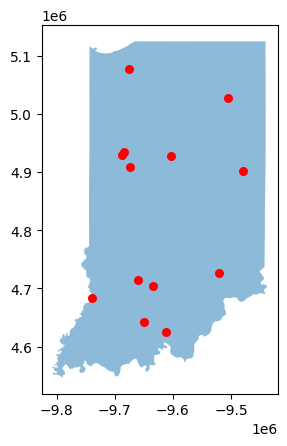

In [6]:
fig, ax = plt.subplots(1,1)
#fig.set_size_inches(10,8.5)
IN_basemap.plot(ax=ax,alpha=0.5)
stationgeo.plot(ax=ax,color='red',markersize=30);

In [331]:
def convertDate(list_):
    list_.remove("")
    list_ = [int(x) for x in list_]
    
    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    days =   [31,28,31,30,31,30,31,31,30,31, 30, 31]
    return sum(days[0:max(months.index(list_[0]),0)]) + list_[1]

In [370]:
wind_dfs = []
mphtoms = 0.44704 # m/s in 1 mph
for file,station in zip(files,stations):
    with open(file, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(1000))
    encoding = result['encoding']
    df = pd.read_csv(file,encoding = encoding,sep='\t')#.drop(columns=['Date'])
    df.index.names=['Day']
    df = df.rename(columns = {'Stn ID':'station','Date':'day','Avg Wind Speed (mph)':'speed','Wind Direction (°)':'direction','Max Wind Gust (mph)':'gust'})
    df['speed'] *= mphtoms
    df['gust'] *= mphtoms
    df['avgvect'] = list(zip(round(df['speed']*np.cos(np.deg2rad(df['direction'])),3),round(df['speed']*np.sin(np.deg2rad(df['direction'])),3)))
    df['gustvect'] = list(zip(round(df['gust']*np.cos(np.deg2rad(df['direction'])),3),round(df['gust']*np.sin(np.deg2rad(df['direction'])),3)))
    df['day'] = df['day'].str.replace("/","-").str.replace("2022","").str.split("-").apply(convertDate)
    wind_dfs.append(df)

In [369]:
for x,y in zip(stationgeo.geometry.x,stationgeo.geometry.y):
    print(x,y)

-9683682.504106868 4934478.312844526
-9612438.029999172 4624730.23179871
-9603532.470735712 4928626.878942881
-9478854.641047245 4902338.38236028
-9634701.928157827 4704497.149535374
-9688135.2837386 4930089.410958572
-9505571.318837631 5027102.849122585
-9675890.13975134 5077459.79987571
-9521156.047548689 4725969.7266431935
-9660305.41104028 4714512.0301077925
-9650286.656868886 4643192.21964251
-9738229.054595573 4683069.852205088
-9673663.749935472 4908174.214183567


In [375]:
stationgeo.iloc[[2]].geometry.x

station
DUNLAP   -9.603532e+06
dtype: float64

In [388]:
for value in stationgeo.ge:
    print(value[0])

POINT (-9683682.504106868 4934478.312844526)
POINT (-9612438.029999172 4624730.23179871)
POINT (-9603532.470735712 4928626.878942881)
POINT (-9478854.641047245 4902338.38236028)
POINT (-9634701.928157827 4704497.149535374)
POINT (-9688135.2837386 4930089.410958572)
POINT (-9505571.318837631 5027102.849122585)
POINT (-9675890.13975134 5077459.79987571)
POINT (-9521156.047548689 4725969.7266431935)
POINT (-9660305.41104028 4714512.0301077925)
POINT (-9650286.656868886 4643192.21964251)
POINT (-9738229.054595573 4683069.852205088)
POINT (-9673663.749935472 4908174.214183567)


In [403]:
wind_dfs[5][wind_dfs[5]['day']==25]['avgv

Day
4    (1.222, -1.18)
Name: avgvect, dtype: object

In [406]:
stationgeo.empty

False